In [1]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Parsing tanggal
def parse_date(date_str):
    return pd.to_datetime(date_str, infer_datetime_format=True)

In [3]:
# Memuat dataset dan mengonversi kolom tanggal
data = pd.read_csv('daily_mean.csv')

In [4]:
# Menghapus nilai nan
data.dropna()

,Lake,Date,Unnamed: 0,Unnamed: 0.1,lat,long,chla,secchi,TP,DOC,...,POC,SRP,TDN,NOx,TN,Year,Month,Day,day_of_year,num_samples


In [5]:
# menunjukkan keberadaan nilai nan
data.isnull()

,Lake,Date,Unnamed: 0,Unnamed: 0.1,lat,long,chla,secchi,TP,DOC,...,POC,SRP,TDN,NOx,TN,Year,Month,Day,day_of_year,num_samples
0,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
1,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
2,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
3,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
4,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52111,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
52112,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
52113,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False
52114,False,False,False,True,True,True,False,True,True,True,...,True,True,True,True,True,False,False,False,False,False


In [6]:
# mengonversi kolom tanggal
data['Date'] = data['Date'].apply(parse_date)

<ipython-input-2-351a4f5dbc0a>:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(date_str, infer_datetime_format=True)


In [7]:
#  Menampilkan kolom Date dan chla
print(data[['Date', 'chla']])

            Date  chla
0     2001-04-17   4.2
1     2001-05-14   9.5
2     2001-06-14  17.5
3     2001-07-16  22.6
4     2001-08-16   6.9
...          ...   ...
52111 2019-06-18   3.2
52112 2019-07-15   7.0
52113 2019-08-15   4.9
52114 2019-09-11   6.4
52115 2019-10-14   2.3

[52116 rows x 2 columns]


In [8]:
# Mengurutkan data berdasarkan kolom Date
data = data.sort_values('Date')

In [9]:
# Mengambil tanggal saja dari Date
data['Date'] = data['Date'].dt.date

In [10]:
# Mengelompokkan data berdasarkan Date dan menghitung rata-rata chla
daily_avg = data.groupby('Date')['chla'].mean().reset_index()

In [11]:
# Mengonversi kolom Date ke format datetime
daily_avg['Date'] = pd.to_datetime(daily_avg['Date'])

In [12]:
# Memisahkan data menjadi training (2001-2017) dan testing (2018-2019)
train_data = daily_avg[(daily_avg['Date'].dt.year >= 2001) & (daily_avg['Date'].dt.year <= 2017)]
test_data = daily_avg[(daily_avg['Date'].dt.year >= 2018) & (daily_avg['Date'].dt.year <= 2019)]

print("Training Data:")
print(train_data)

print("\nTesting Data:")
print(test_data)

Training Data:
            Date       chla
5735  2001-01-01  17.835000
5736  2001-01-08   6.400000
5737  2001-01-09   6.192222
5738  2001-01-10  25.442857
5739  2001-01-15  31.600000
...          ...        ...
10079 2017-12-15   8.985714
10080 2017-12-18   7.600000
10081 2017-12-19   5.370000
10082 2017-12-28  44.350000
10083 2017-12-29   3.100000

[4349 rows x 2 columns]

Testing Data:
            Date        chla
10084 2018-01-01  159.751140
10085 2018-01-02   38.800000
10086 2018-01-03   14.325000
10087 2018-01-04   18.133333
10088 2018-01-05   63.490000
...          ...         ...
10589 2019-12-16    2.360000
10590 2019-12-17    2.050000
10591 2019-12-18   10.730000
10592 2019-12-19    3.500000
10593 2019-12-23    3.300000

[510 rows x 2 columns]


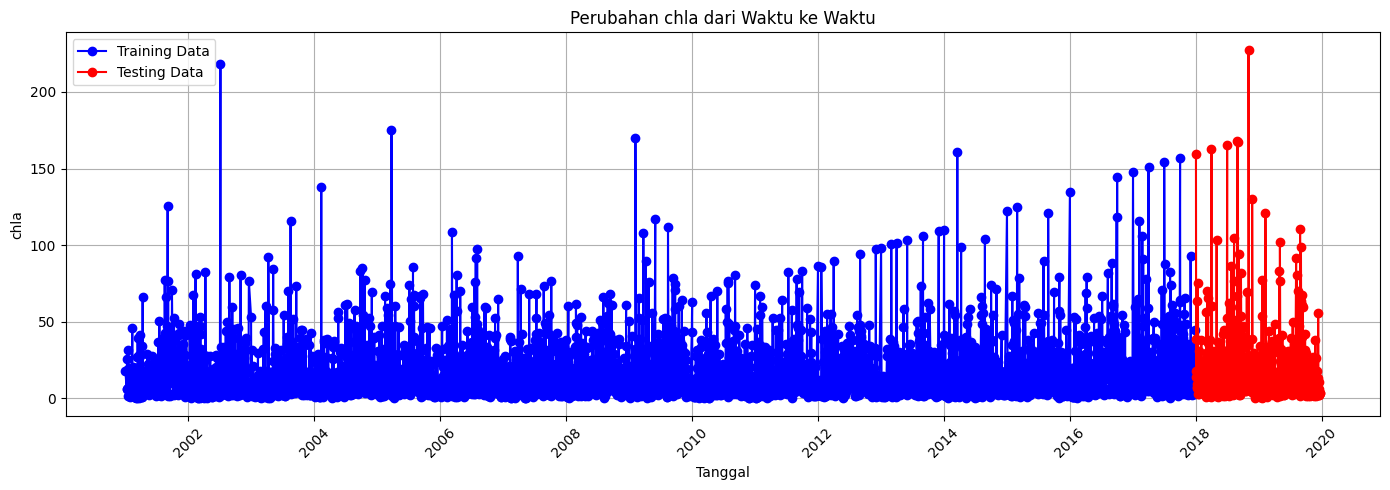

In [13]:
# Membuat grafik perubahan chla dari waktu ke waktu
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['chla'], label='Training Data', marker='o', linestyle='-', color='b')
plt.plot(test_data['Date'], test_data['chla'], label='Testing Data', marker='o', linestyle='-', color='r')
plt.title('Perubahan chla dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('chla')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Menghitung Moving Average untuk data training dan testing
window_size = 7
train_data['MOVING_AVG'] = train_data['chla'].rolling(window=window_size).mean()
test_data['MOVING_AVG'] = test_data['chla'].rolling(window=window_size).mean()

<ipython-input-14-ddb316f45f03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['MOVING_AVG'] = train_data['chla'].rolling(window=window_size).mean()
<ipython-input-14-ddb316f45f03>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['MOVING_AVG'] = test_data['chla'].rolling(window=window_size).mean()


In [15]:
# Menghapus nilai NaN yang mungkin ada setelah menghitung Moving Average
train_data = train_data.dropna()
test_data = test_data.dropna()

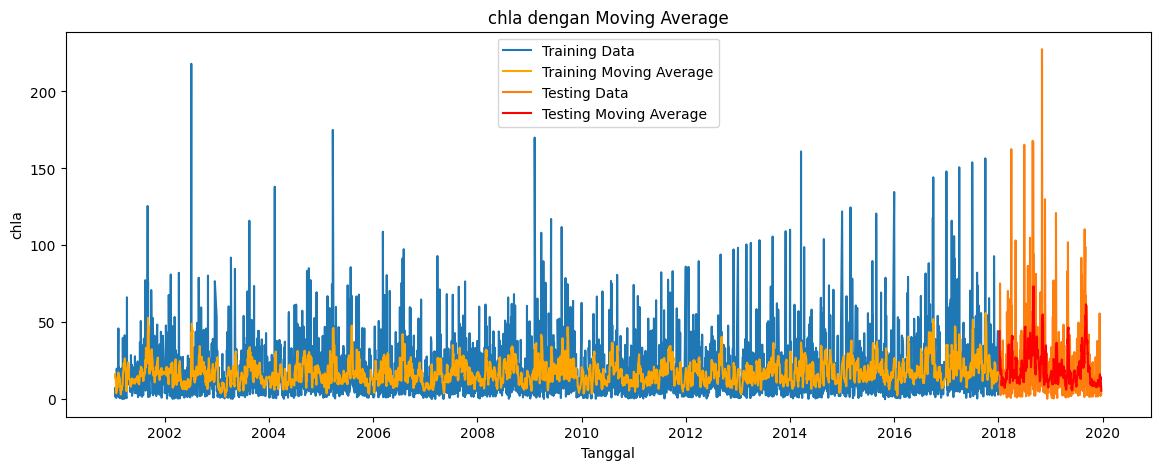

In [16]:
# Menampilkan grafik Moving Average
plt.figure(figsize=(14, 5))
plt.plot(train_data['Date'], train_data['chla'], label='Training Data')
plt.plot(train_data['Date'], train_data['MOVING_AVG'], label='Training Moving Average', color='orange')
plt.plot(test_data['Date'], test_data['chla'], label='Testing Data')
plt.plot(test_data['Date'], test_data['MOVING_AVG'], label='Testing Moving Average', color='red')
plt.title('chla dengan Moving Average')
plt.xlabel('Tanggal')
plt.ylabel('chla')
plt.legend()
plt.show()

In [17]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['MOVING_AVG']])
test_scaled = scaler.transform(test_data[['MOVING_AVG']])

In [18]:
# Fungsi untuk membuat sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

In [19]:
# Menentukan panjang sequence
seq_length = 30
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [20]:
# Membangun model RNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Callback untuk early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Melatih model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/60
135/135 [==============================] - 5s 19ms/step - loss: 0.0455 - val_loss: 0.0091
Epoch 2/60
135/135 [==============================] - 3s 25ms/step - loss: 0.0115 - val_loss: 0.0079
Epoch 3/60
135/135 [==============================] - 2s 18ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 4/60
135/135 [==============================] - 3s 21ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/60
135/135 [==============================] - 2s 16ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 6/60
135/135 [==============================] - 2s 16ms/step - loss: 0.0049 - val_loss: 0.0059
Epoch 7/60
135/135 [==============================] - 3s 22ms/step - loss: 0.0047 - val_loss: 0.0058
Epoch 8/60
135/135 [==============================] - 3s 21ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 9/60
135/135 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 10/60
135/135 [==============================] - 2s 16ms/step - loss: 0.0039 - val_lo

In [23]:
# Mendapatkan nilai akhir dari training loss dan validation loss
final_training_loss = history.history['loss'][-1]
final_validation_loss = history.history['val_loss'][-1]

In [24]:
# Menampilkan hasil evaluasi
print(f'Final Training Loss: {final_training_loss:.4f}')
print(f'Final Validation Loss: {final_validation_loss:.4f}')

Final Training Loss: 0.0031
Final Validation Loss: 0.0057


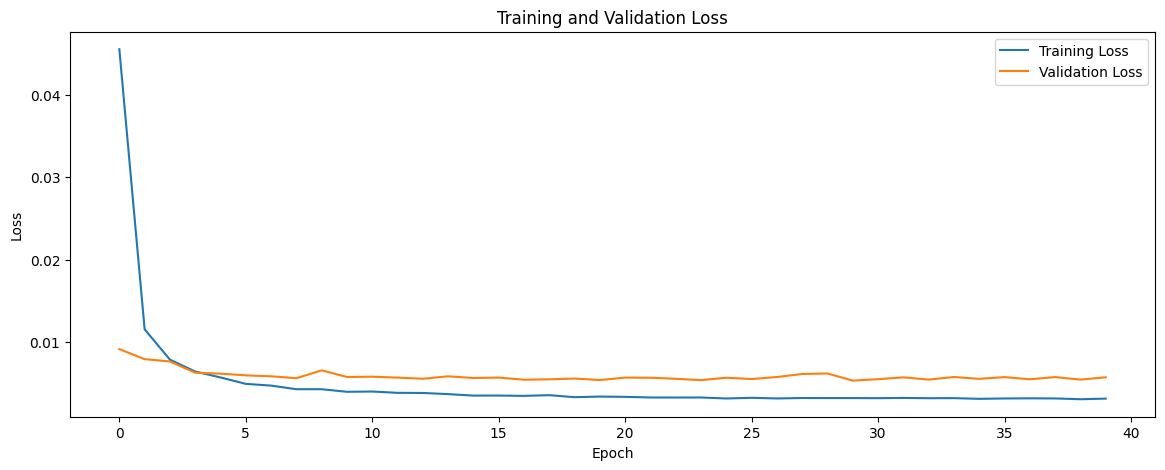

In [25]:
# Plot loss dan validation loss selama pelatihan
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
# Memprediksi data testing
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

15/15 [==============================] - 1s 9ms/step


In [27]:
# Menghitung metrik evaluasi
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [28]:
# Menghitung metrik evaluasi
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

In [29]:
# Tampilkan metrik evaluasi
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 15.695107602284995
RMSE: 3.9617051382308848
MAE: 2.4926394270002104
R²: 0.8948071357824962


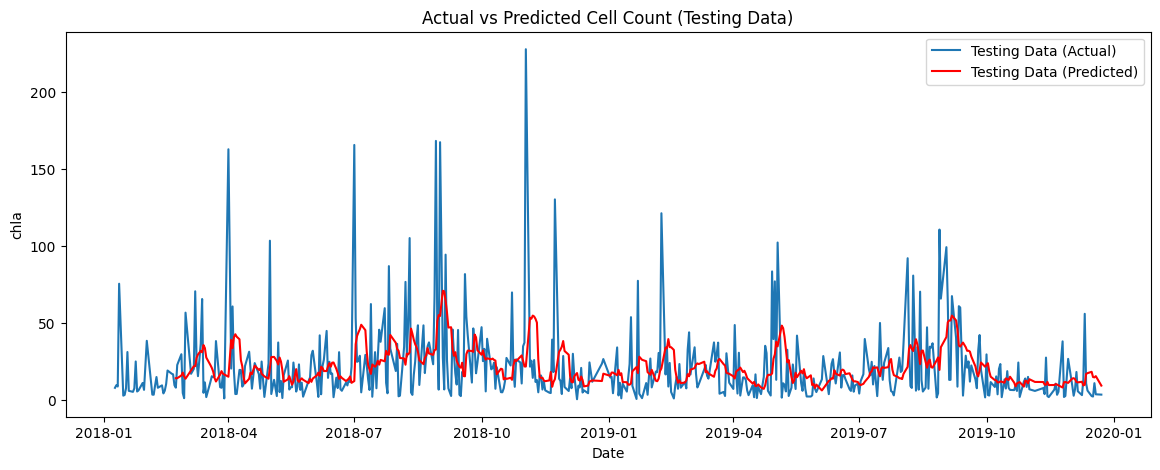

In [31]:
# Plot hasil prediksi dan data asli untuk data testing
plt.figure(figsize=(14, 5))
plt.plot(test_data['Date'], test_data['chla'], label='Testing Data (Actual)')
plt.plot(test_data['Date'][seq_length:], predictions, label='Testing Data (Predicted)', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('chla')
plt.title('Actual vs Predicted Cell Count (Testing Data)')
plt.show()